<a href="https://colab.research.google.com/github/Leo-Foletto98/Deep_Learning/blob/main/F06_Backpropagation_no_Dataset_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo desse projeto é implementar uma rede neural estilo perceptron para classificar as espécies de plantas da base de dados Iris, com base nas entradas de largura e comprimento de pétalas e sépalas. Para este exercício você não deve usar bibliotecas prontas como Tensorflow e Keras, nem Pandas. Utilize apenas funcionalidades nativas do Python, NumPy e Matplotlib para geração dos gráficos.

Critérios:


1.   Fazer a leitura dos dados, criando o par de matrizes X e Y no formato array do numpy, com 150 linhas cada, onde X têm 4 colunas e Y tem 3 colunas. X é o conjunto de dados de largura e comprimento de sépalas e pétalas, e Y é a classe da planta no formato one-hot.

2.   Embaralhar e separar 10% dos dados para validação, com o cuidado de manter os pares correspondentes no processo.

3.   Criar uma classe que implemente uma rede do tipo perceptron, com três camadas, tendo 5 neurônios na primeira camada, 4 na segunda e 3 na saída. Utilizando a função de ativação sigmoide. A rede deve inicializar todos pesos e biases com valores aleatórios distribuídos uniformemente entre -1 e 1. Implementar o código que realiza a propagação direta das sinapses, recebendo uma amostra x (uma linha de X dos dados de treinamento ou validação) e calcular uma saída Y no formato correto. Tomar o cuidado para usar a função reshape para transformar os dados de entrada para o formato de vetor coluna, mantendo o código compatível com a notação apresentada nas videoaulas. No contrutor essa classe deve definir também um passo de aprendizagem eta.

4.   Implementar o método que executa o algoritmo backpropagation. Esse método deve receber um par de entradas e saídas desejadas, transformá-los para o formato coluna usando a função reshape, e com base nisso calcular os deltas da camada de saída, e a partir desse, propagar o resultado calculando os deltas das camadas anteriores, uma a uma, da saída até a entrada. Garantir que as dimensões dos vetores e matrizes estejam corretas. Em seguida calcular e efetuar a correção dos valores dos pesos e biases de cada camada utilizando o valor de passo de aprendizagem eta definido no construtor.

5.   Escrever código que crie um objeto da classe perceptron e faça o treinamento da rede neural com base nos dados separados para trenamento.

6.   Gravar o valor do erro ao longo do treinamento e gere um gráfico demonstrando como ele se reduziu a cada interação.



# 1 Upload do Arquivo

Use o espaço abaixo para fazer o upload do arquivo para o ambiente do Google Colab. Para isso você pode usar o comando `gdown` (lembre-se de colocar o sinal de exclamação `!` para chamar comandos na linha de comando, fora do Python).

In [ ]:
from google.colab import files
import io
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import random

upload = files.upload()
f = io.BytesIO(upload['Iris.csv'])

Saving Iris.csv to Iris.csv


In [ ]:
# Zeramos o cursor para garantir que a leitura
# do arquivo inicie do início
f.seek(0)

# A variável lines é uma lista que contém as strings
# que representam cada linha do arquivo lido.
lines = f.readlines()

In [ ]:
# Aqui criamos as matrizes de entradas e saídas correspondentes
# ainda vazias
X = np.zeros((len(lines)-1,4)) # 4 entradas
Y = np.zeros((len(lines)-1,3)) # 3 saídas (one-hot encoding)

# Teremos 3 categorias. O vetor abaixo lista as strings
# que representam as categorias possíveis
cat = np.array(['Iris-setosa','Iris-versicolor','Iris-virginica'])

In [ ]:
# Para cada linha do arquivo, exceto
# a primeira linha que é o cabeçalho
for i, line in enumerate(lines[1:]):

  # Aqui decodificamos a linha para transformar
  # de binário para caracteres ascii, e descartamos
  # o último caractere que representa uma nova linha
  s = line.decode()[:-1]

  # Aqui separamos os dados por vírgulas,
  # descartando o primeiro valor que é o id
  # pois usaremos i do laço como id.
  _,sl,sw,pl,pw,sp = s.split(',')

  # Transformamos as strings que representam
  # as dimensões de sépala e pétala para ponto
  # flutuante.
  sl = float(sl)
  sw = float(sw)
  pl = float(pl)
  pw = float(pw)

  # Aqui populamos as matrizes X e Y com os dados
  # coletados.
  X[i:] = np.array([sl,sw,pl,pw])
  Y[i:] = (cat == sp).astype('float') # Atenção para essa linha!

  # A última linha acima merece uma explicação mais longa:
  # Nessa linha fazemos um teste booleano, comparando cada
  # elemento do vetor cat com a string daquela linha do arquivo.
  # Para os elementos onde a comparação der verdadeiro, teremos
  # um booleano True, e para os elementos onde a comparação
  # der falso, teremos um booleano False. O resultado da comparação
  # do vetor cat com a string sp, na expressão cat == sp resulta
  # numa array booleana com mesmo formato que cat, mas com
  # valores booleanos True ou False em cada posição. O método
  # .astype('float') transforma o resultado em um array de float,
  # com 1.0 representando True e 0.0 representando False.
  # Então transformamos uma string como 'Iris-setosa' no vetor
  # [1.0, 0.0, 0.0] e uma string como 'Iris-versicolor' no vetor
  # [0.0, 1.0, 0.0] e assim por diante.

In [ ]:
# Aqui criamos uma lista de índices
# embaralhados
indexes = list(range(150))
random.shuffle(indexes)

# Essa variável T indica quantas amostras
# serão usadas para treinamento. As demais
# serão usadas para validação
T = int(150*0.1)

# Aqui preparamos as matrizes dos pares
# de dados de treinamento e validação.
Xt = np.zeros((T,4))
Yt = np.zeros((T,3))
Xv = np.zeros((150-T,4))
Yv = np.zeros((150-T,3))

# Aqui preenchemos as matrizes com os
# respectivos valores
for i in range(0,T):
  Xt[i,:] = X[indexes[i],:]
  Yt[i,:] = Y[indexes[i],:]
for i in range(0,150-T):
  Xv[i,:] = X[indexes[T+i],:]
  Yv[i,:] = Y[indexes[T+i],:]

In [ ]:
# Função de ativação
def sigmoid(s, deriv=False):
    if (deriv == True):
        return s * (1 - s)
    return 1/(1 + np.exp(-s))

# Função softmax
def softmax(x):
  ex = np.exp(x*10)
  s = np.sum(ex)
  return ex/s

In [ ]:
# Definição da rede perceptron
# input_size - número de neurônios na camada de entrada
# hidden_layer - lista contendo o número de neurônios em cada camada oculta
# output_layer - número de neurônios na camada de saída
class Perceptron:
    def __init__(self, input_size, hidden_layer, output_layer):
        self.input_size = input_size
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

        # Inicialização aleatória dos pesos e bias para as camadas ocultas
        pLayer = self.input_size
        self.wh = []  # Pesos das camadas ocultas
        self.bh = []  # Bias das camadas ocultas

        for e, it in enumerate(self.hidden_layer):
            # Inicialização aleatória dos pesos e bias para cada camada oculta
            self.wh.append(np.random.random((it, pLayer)) * 2.0 - 1.0)
            self.bh.append(np.random.random((it, 1)) * 2.0 - 1.0)
            pLayer = it

        # Inicialização aleatória dos pesos e bias para a última camada
        self.wo = np.random.random((self.output_layer, self.hidden_layer[-1])) * 2.0 - 1.0
        self.bo = np.random.random((self.output_layer, 1)) * 2.0 - 1.0

        # Definição da taxa de aprendizado
        self.eta = 0.05

    def forward(self, x):
        # Ajustar o formato de entrada para ser um vetor coluna
        x = np.reshape(x, (self.input_size, 1))

        # Cálculo de S e Z para as camadas ocultas
        self.sh = []  # Saída da camada oculta
        self.zh = []  # Saída após função de ativação sigmoide
        pLayer = x

        for e, whl in enumerate(self.wh):
            # Cálculo de Sh (soma ponderada)
            tmpSh = np.dot(whl, pLayer) + self.bh[e]
            # Cálculo de Zh (saída após função de ativação sigmoide)
            tmpZh = sigmoid(tmpSh)  # Função de ativação sigmoide

            self.sh.append(tmpSh)
            self.zh.append(tmpZh)

            # Atualiza a camada para calcular a próxima Sh em relação ao Zh da camada anterior
            pLayer = tmpZh

        # Cálculo de S e Z para a camada de saída
        self.so = np.dot(self.wo, self.zh[-1]) + self.bo
        self.zo = sigmoid(self.so)  # Saída após função de ativação sigmoide

        # Retorna a saída calculada
        return softmax(self.zo)

    def train(self, Xt, Yt):
        Err = 0

        for n in range(len(Xt)):
            # Converte a entrada para um array numpy
            X = np.asarray(Xt[n])
            X = np.reshape(X, (self.input_size, 1))

            Y = Yt[n]
            Y = np.reshape(Y, (self.output_layer, 1))

            # Obtém a saída da rede para a entrada X, salvando em ŷ
            self.yhat = self.forward(X)

            # Cálculo do erro RMSE (Root Mean Square Error)
            Err = sqrt(mean_squared_error(Y, self.yhat))

            # Ajusta os pesos e bias por meio do backpropagation
            self.backpropagation(X, Y)

        # Retorna o erro
        return Err

    def backpropagation(self, X, Y):
        # Cálculo do delta para a camada de saída
        # ((Z^L) - ŷ) * drv(S^L) onde drv é a derivada da função sigmoide
        dout = (self.yhat - Y) * (sigmoid(self.zo, True))

        # Cálculo da derivada do erro em relação aos pesos da camada de saída
        dEwo = np.dot(dout, self.zh[-1].T)

        # Atualização dos pesos e bias da camada de saída
        self.bo = self.bo - (self.eta * dout)
        self.wo = self.wo - (self.eta * dEwo)

        # Cálculo do delta para as camadas ocultas
        # (W^(l+1).T) x delta^(l+1)) * drv(S^l) onde drv é a derivada da função sigmoide
        pLayerW = self.wo
        pLayerD = dout
        pZ = len(self.zh) - 1

        dHi = []  # Delta
        dEwh = []  # Derivada do erro em relação aos pesos

        for e, it in enumerate(reversed(self.zh), start=1):
            tmpDelta = (np.dot(pLayerW.T, pLayerD)) * (sigmoid(it, True))
            dHi.append(tmpDelta)

            # Derivada do erro em relação aos pesos
            if pZ > 0:
                tmpDerr = np.dot(tmpDelta, (self.zh[pZ - 1]).T)
            else:
                tmpDerr = np.dot(tmpDelta, (X.T))

            # Atualiza a iteração
            pZ -= 1
            dEwh.append(tmpDerr)

            # Atualiza as camadas
            pLayerW = self.wh[-e]
            pLayerD = tmpDelta

            # Ajusta os pesos e bias das camadas ocultas
            self.bh[-e] = self.bh[-e] - (self.eta * tmpDelta)
            self.wh[-e] = self.wh[-e] - (self.eta * tmpDerr)

In [ ]:
#Definindo a rede
n_entradas = 4
c_ocultas = [5,4]
n_saidas = 3

# Criando a rede neural
p = perceptron(n_entradas, c_ocultas, n_saidas)
Errl = []

# Treino 10K
for i in range(10000):
  Err = p.train(Xt,Yt)
  #A cada 1000, print do erro calculado
  if not (i % 1000) or i == 0:
    print('RMSE = ',Err)
    Errl.append(Err)

RMSE =  0.7368999952258859
RMSE =  0.022660705619756326
RMSE =  0.008275486959792588
RMSE =  0.0049572018392473535
RMSE =  0.003558152401431222
RMSE =  0.0027946651250133404
RMSE =  0.0023149881393357244
RMSE =  0.0019857328323996913
RMSE =  0.0017455942456632006
RMSE =  0.0015625519314268646


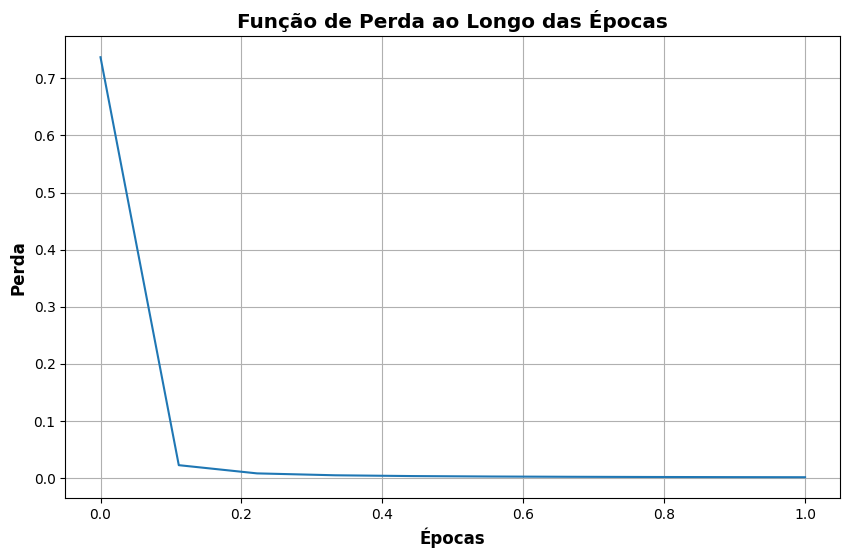

In [ ]:
# Plotando a Função de Perda
ax = np.linspace(0, len(Errl) / 10, len(Errl), endpoint=True)
plt.figure('Função de Perda ao Longo das Épocas', figsize=(10, 6))
plt.plot(ax, Errl)
plt.title("Função de Perda ao Longo das Épocas", fontsize='x-large', fontweight='bold')
plt.ylabel("Perda", fontsize='large', fontweight='bold')
plt.xlabel("Épocas", fontsize='large', fontweight='bold')
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.show()